# Import supporting package

In [1]:
import xarray as xr
import numpy as np

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

import matplotlib.pyplot as plt

from DataContainer.ReadData import read_hdf5_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from ToolFunction.ToolFunction import *

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()

## Start a client for parallel computing

In [2]:
from dask.distributed import Client
client = Client(n_workers=6, threads_per_worker=10, processes=True, memory_limit='10GB')
client

<Client: 'tcp://127.0.0.1:63901' processes=6 threads=60, memory=55.88 GiB>

# Read data

## Set file path

In [3]:
# filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/05/03/0043/*.h5"
# filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/04/18/0003/2023-04-18_0003_Evaporative_Cooling_000.h5"

# filepath = "//DyLabNAS/Data/Repetition_scan/2023/04/21/0002/*.h5"

# filepath = r"./testData/0000/*.h5"

# filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/04/18/0003/*.h5"

filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/05/04/0000/*.h5"

In [4]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    # "images/ODT_1_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_1",
    # "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_2",
}

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filepath, groupList[i])
    for i in range(len(groupList))
}

## Rechunk the data for parallel computing

In [5]:
dataSet = dataSetDict["camera_1"]

scanAxis = dataSet.scanAxis

# dataSet = dataSet.chunk(
#     {
#         # "compZ_current_sg": "auto",
#         "sin_mod_freq": "auto",
#         "runs": 2,
#         "x": "auto",
#         "y": "auto",
#     }
# )

# Calculate absorption imaging

## get OD images

In [6]:
dataSet = imageAnalyser.get_absorption_images(dataSet)

dataSet

<xarray.Dataset>
Dimensions:     (runs: 3, x: 1200, y: 1920)
Coordinates:
  * runs        (runs) float64 0.0 1.0 2.0
Dimensions without coordinates: x, y
Data variables:
    atoms       (runs, x, y) uint16 dask.array<chunksize=(1, 1200, 1920), meta=np.ndarray>
    background  (runs, x, y) uint16 dask.array<chunksize=(1, 1200, 1920), meta=np.ndarray>
    dark        (runs, x, y) uint16 dask.array<chunksize=(1, 1200, 1920), meta=np.ndarray>
    shotNum     (runs) <U1 '0' '1' '2'
    OD          (runs, x, y) float64 dask.array<chunksize=(1, 1200, 1920), meta=np.ndarray>
Attributes: (12/101)
    TOF_free:                          0.015
    abs_img_freq:                      110.858
    absorption_imaging_flag:           True
    backup_data:                       True
    blink_off_time:                    nan
    blink_on_time:                     nan
    ...                                ...
    y_offset_img:                      0
    z_offset:                          0.189
    z_offset_img:                      0.189
    runs:                              [0. 1. 2.]
    scanAxis:                          ['runs']
    scanAxisLength:                    [3.]

## Select region of interests

In [7]:
imageAnalyser.center = (529, 962)
imageAnalyser.span = (100,100)
imageAnalyser.fraction = (0.1, 0.1)

# imageAnalyser.center = (890, 1150)
# imageAnalyser.span = (600,600)
# imageAnalyser.fraction = (0.1, 0.1)

# imageAnalyser.center = (890, 950)
# imageAnalyser.span = (100,100)
# imageAnalyser.fraction = (0.1, 0.1)

dataSet_crop = imageAnalyser.crop_image(dataSet)

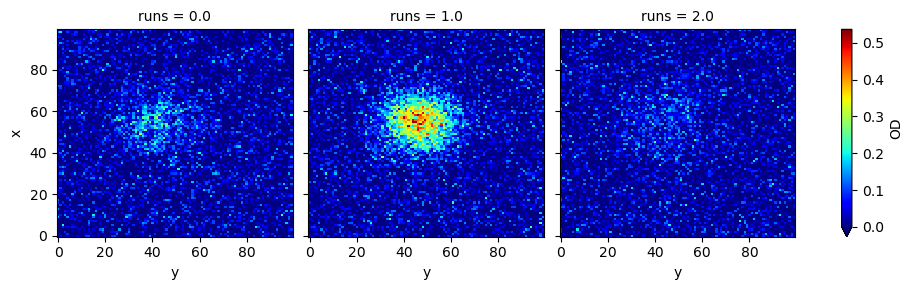

In [8]:
# dataSet_crop.OD.isel(runs=[0]).plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])
dataSet_crop.OD.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0])

## Remove the background

In [9]:
dataSet_crop['OD'] = dataSet_crop['OD'] + 500

In [10]:
dataSet_crop['OD'] = imageAnalyser.substract_offset(dataSet_crop['OD'])

# Test Fit

In [11]:
fitAnalyser = FitAnalyser("Two Gaussian-2D", fitDim=2)

params = fitAnalyser.guess(dataSet_crop.OD, dask="parallelized")

In [12]:
fitResult = fitAnalyser.fit(dataSet_crop.OD, params, dask="parallelized")# .load()

In [13]:
fitCurve = fitAnalyser.eval(fitResult, x=np.arange(100), y=np.arange(100), dask="parallelized").load()

In [14]:
fitCurve

<xarray.DataArray 'OD' (runs: 3, x: 100, y: 100)>
array([[[5.86966574e-10, 7.65249266e-10, 9.91509448e-10, ...,
         2.46154913e-11, 1.75761294e-11, 1.24721796e-11],
        [9.42954541e-10, 1.22936348e-09, 1.59284766e-09, ...,
         3.95444823e-11, 2.82358344e-11, 2.00364022e-11],
        [1.50191506e-09, 1.95810025e-09, 2.53704902e-09, ...,
         6.29854895e-11, 4.49733502e-11, 3.19134941e-11],
        ...,
        [2.54388919e-07, 3.31655910e-07, 4.29716150e-07, ...,
         1.06682535e-08, 7.61742276e-09, 5.40539175e-09],
        [1.77937216e-07, 2.31983098e-07, 3.00573216e-07, ...,
         7.46211487e-09, 5.32815269e-09, 3.78090510e-09],
        [1.23399279e-07, 1.60880043e-07, 2.08447221e-07, ...,
         5.17496911e-09, 3.69506849e-09, 2.62205386e-09]],

       [[9.02404312e-13, 1.36226913e-12, 2.03826777e-12, ...,
         2.07414123e-13, 1.32113406e-13, 8.34049874e-14],
        [1.66705507e-12, 2.51658556e-12, 3.76539048e-12, ...,
         3.83166126e-13, 2.44059476e-13, 1.54078061e-13],
        [3.04507755e-12, 4.59684767e-12, 6.87794078e-12, ...,
         6.99899236e-13, 4.45804128e-13, 2.81442200e-13],
...
        [9.87414581e-10, 1.49060060e-09, 2.23028114e-09, ...,
         2.26953403e-10, 1.44559043e-10, 9.12620869e-11],
        [6.10537300e-10, 9.21666828e-10, 1.37902544e-09, ...,
         1.40329625e-10, 8.93836181e-11, 5.64290919e-11],
        [3.73271211e-10, 5.63490048e-10, 8.43110640e-10, ...,
         8.57949366e-11, 5.46474905e-11, 3.44997029e-11]],

       [[3.50772829e-03, 3.51239608e-03, 3.51706888e-03, ...,
         3.97151663e-03, 3.97641278e-03, 3.98131117e-03],
        [3.50458735e-03, 3.50925410e-03, 3.51392671e-03, ...,
         3.96794908e-03, 3.97284066e-03, 3.97773453e-03],
        [3.50066142e-03, 3.50532717e-03, 3.50999990e-03, ...,
         3.96348891e-03, 3.96837476e-03, 3.97326297e-03],
        ...,
        [1.12548401e-03, 1.12795860e-03, 1.13069623e-03, ...,
         1.27078253e-03, 1.27229756e-03, 1.27382711e-03],
        [1.09950837e-03, 1.10175364e-03, 1.10420980e-03, ...,
         1.24207255e-03, 1.24356247e-03, 1.24506415e-03],
        [1.07397978e-03, 1.07603161e-03, 1.07825160e-03, ...,
         1.21374189e-03, 1.21520532e-03, 1.21667822e-03]]])
Coordinates:
  * runs     (runs) float64 0.0 1.0 2.0
Dimensions without coordinates: x, y

In [15]:
fitResult = fitAnalyser.fit(dataSet_crop.OD, params, dask="parallelized").load()

In [16]:
fitCurve = fitAnalyser.eval(fitResult, x=np.arange(100), y=np.arange(100), dask="parallelized").load()

In [ ]:
auto_rechunk(fitResult)
fitResult

In [ ]:
# fitCurve.isel(**{scanAxis[0]:np.arange(30), 'runs':range(dataSet_crop.OD['runs'].size)}).plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])

fitCurve.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0])

In [ ]:
fitResult.load()

In [ ]:
def resolve_fit_result(fitResult):
    
    
    
    return

# Get the Ncount

In [18]:
Ncount = dataSet_crop.OD.sum(dim=(scanAxis[0], 'x', 'y'))

TypeError: No numeric data to plot.

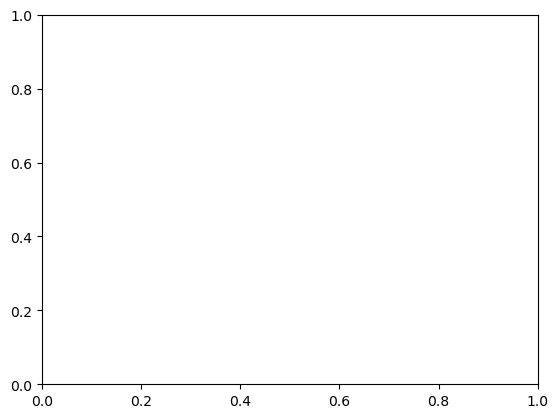

In [19]:
Ncount.load()

fig = plt.figure()
ax = fig.gca()
Ncount.plot(ax=ax)

In [ ]:
fitAnalyser = FitAnalyser("Lorentzian With Offset")
params = fitAnalyser.guess(Ncount, x='sin_mod_freq', dask="parallelized", guess_kwargs=dict(negative=True))

In [ ]:
fitResult = fitAnalyser.fit(Ncount, params, x='sin_mod_freq', dask="parallelized")
fitCurve = fitAnalyser.eval(fitResult, x=np.arange(40), dask="parallelized").load()

In [ ]:
fig = plt.figure()
ax = fig.gca()
plt.errorbar([1], [1], yerr=[1])

In [ ]:
fitCurve.plot.errorbar(yerr=fitCurve)

In [ ]:
np.ufunc(fitCurve)